In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
plt.rcdefaults()

In [16]:
'''In this scan, I will FIX values for certain things, let us do that in here!'''

#EVERYTHING IN GeV UNLESS STATED OTHERWISE

vH = 246

#Central Values from NuFit 6.1 (2025):
delta_m21_sq = 7.537e-5 #eV^2
delta_m31_sq = 2.521e-3 #eV^2 (Normal Ordering)
delta_m32_sq = -2.511e-3 #eV^2 (Inverted Ordering)

#The greateste value of the error bar in 1 sigma for each mass from NuFit 6.1, because they are antisymmetric:

sigma21 = 0.1e-5 #eV^2
sigma31 = 0.026e-3 #eV^2
sigma32 = 0.021e-3 #eV^2

theta12_degrees = 33.76
theta23_degreesNO = 43.27
theta13_degreesNO = 8.62

#Let us define the errors for N.O:

sigma_theta12 = 0.42
sigma_theta23 = 1
sigma_theta13 = 0.11

theta23_degreesIO = 43.29 #This is the only one that changes in NuFit


delta_cpNO = 177 #degrees
delta_cpIO = 212 #degrees


#Now, we generate values in the 1\sigma range for the masses and angles:

m21 =np.random.uniform(delta_m21_sq - sigma21, delta_m21_sq + sigma21)
m31 = np.random.uniform(delta_m31_sq - sigma31, delta_m31_sq + sigma31)
m32 = np.random.uniform(abs(delta_m32_sq) - sigma32, abs(delta_m32_sq) + sigma32)

#ANGLES WILL BE ALREADY IN RADIANS
theta12 = np.deg2rad(np.random.uniform(theta12_degrees - 0.41, theta12_degrees + 0.42))
theta23NO = np.deg2rad(np.random.uniform(theta23_degreesNO - 0.82, theta23_degreesNO + 1))
theta13NO = np.deg2rad(np.random.uniform(theta13_degreesNO - 0.11, theta13_degreesNO + 0.11))
theta23IO = np.deg2rad(np.random.uniform(theta23_degreesIO - 0.79, theta23_degreesIO + 0.96))
deltaCPNO = np.deg2rad(np.random.uniform(delta_cpNO - 20, delta_cpNO + 19))
deltaCPIO = np.deg2rad(np.random.uniform(delta_cpIO - 41, delta_cpIO + 26))
#First, for Normal Ordering:

m1NO = 0
m2NO = np.sqrt(m21) * 1e-9
m3NO = np.sqrt(m31) * 1e-9

light_neutrinos = np.array([m1NO, m2NO, m3NO])

#Now, Invert Ordering:

m3IO = 0
m2IO = np.sqrt(m32) * 1e-9
m1IO = np.sqrt(m32 - m21) * 1e-9

In [17]:
'''Defining PMNS matrix for NO:'''

pmns_1 = np.array([
    [1,0,0],
    [0, np.cos(theta23NO), np.sin(theta23NO)],
    [0, -np.sin(theta23NO), np.cos(theta23NO)]
])

pmns_2 = np.array([
    [np.cos(theta13NO), 0, np.sin(theta13NO)*np.exp(-1j*deltaCPNO)],
    [0,1,0],
    [-np.sin(theta13NO)*np.exp(1j*deltaCPNO), 0, np.cos(theta13NO)]
])

pmns_3 = np.array([
    [np.cos(theta12), np.sin(theta12), 0],
    [-np.sin(theta12), np.cos(theta12), 0],
    [0,0,1]
])

pmns_NO = pmns_1 @ pmns_2 @ pmns_3

In [18]:
'''mL will be generated from the Seesaw formula, we only need the other Yukawas'''

A = (np.random.uniform(5e-8, 1.5e-7, (3,3)) + 1j*np.random.uniform(0.5e-8, 1.5e-7, (3,3)))
mR = (A + A.T)/2 #Making sure the matrix is symmetric
C = (np.random.uniform(10, 246, (3,3)) + 1j*np.random.uniform(10, 246, (3,3)))
mD = C
D = (np.random.uniform(500, 1500,(3,3)) + 1j*np.random.uniform(500, 1500, (3,3)))
mN = D

In [19]:
'''This is the eta matrix for LFC and LFV at 95% CL from 2306.01040. Here, the diagonal elements are random within the allowed ranges and the off-diagonals are fixed
upper bounds. This will be used to get an order of magnitude in m_N from an approximation I found. I am also assuming that the complex phases are zero for simplicity'''

eta_data = np.array([
    [np.random.uniform(0.2e-3,1.65e-3), 7.2e-6, 4.9e-3],
    [7.2e-6, np.random.uniform(-1.1e-3, -0.088e-3), 5.6e-3],
    [4.9e-3, 5.6e-3, np.random.uniform(-3.1e-3,0.56e-3)]
])

#Let us use now the formula:

mN_approx_sqr = 1/2 * mD.conj() @ eta_data @ mD.T.conj()

mN_approx_sqr

array([[ 69.00009373-144.36257653j,  -3.13581078-292.8189318j ,
         -2.09681295-214.66140593j],
       [ -3.13581078-292.8189318j , -67.33737214-282.10698329j,
          4.93480728-261.28748137j],
       [ -2.09681295-214.66140593j,   4.93480728-261.28748137j,
         26.3648523 -246.08416118j]])

In [20]:
'''The thing is, I can get lambdaL or mL from the seesaw formula, so I will do that.'''

mL = mN @ np.linalg.inv(mD.T) @ np.linalg.inv(pmns_NO.T) @ np.diag([m1NO, m2NO, m3NO]) @ np.linalg.inv(pmns_NO) @ np.linalg.inv(mD) @ mN.T

mL

array([[3.50817762e-10-1.17336033e-09j, 1.12644583e-09-4.36302734e-10j,
        1.25665105e-09-1.83449283e-09j],
       [1.12644583e-09-4.36302734e-10j, 1.14463888e-09+4.57377397e-10j,
        2.16270726e-09-6.15611553e-10j],
       [1.25665105e-09-1.83449283e-09j, 2.16270726e-09-6.15611553e-10j,
        2.35732827e-09-3.32025903e-09j]])

In [ ]:
'''Let us do a run, then.'''

'''In here I scan over the parameter space ensuring that the stringest LFV bound is satisfied. Then, I store the lightest heavy neutrino mass vs the VEV vS.'''


from scipy.stats import chi2
chi2_accepted = chi2.ppf(0.997, df=2)
chi2_3dof = chi2.ppf(0.997, df=3)



#vS_values = np.logspace(np.log10(300), np.log10(3000), 100) #VEV in GeV
vS_values = np.linspace(300, 3000, 100) #VEV in GeV
G1 = []
W1 = []
heavy_masses = []
light_heavy = []
light_heavy_passes = []
eta_limit = 7.2e-6 #This is on \eta_{e \mu} at 95%C.L.
N_inner = 1000
masses = [] #Heavy masses using eigvals istead of SVD.

for vS in vS_values:
    for i in range(N_inner):
        lambdaN = np.random.uniform(0.5, 1.0, (3,3)) * np.exp(1j*np.random.uniform(0,2*np.pi,(3,3)))
        lambdaR_generation = (np.random.uniform(0.5e-12, 1.5e-12, (3,3))) * np.exp(1j*np.random.uniform(0,2*np.pi,(3,3)))
        lambdaR = (lambdaR_generation + lambdaR_generation.T)/2
        lambdaD = np.random.uniform(1e-3, 1e-2, (3,3)) * np.exp(1j*np.random.uniform(0,2*np.pi,(3,3)))
        yL = np.sqrt(2) * (vS/vH**2) * lambdaN @ np.linalg.inv(lambdaD.T) @ np.linalg.inv(pmns_NO.T) @ np.diag([m1NO, m2NO, m3NO]) @ np.linalg.inv(pmns_NO) @ np.linalg.inv(lambdaD) @ lambdaN.T
        mN, mR, mD, mL = (vS*lambdaN)/np.sqrt(2), (vS*lambdaR)/np.sqrt(2), (vH*lambdaD)/np.sqrt(2), (vS*yL)/np.sqrt(2)
        MD = np.block([
            [mD],
            [np.zeros((3,3))]
        ])
        MS = np.block([
        [mR, mN.T],
        [mN, mL]
                    ])
        G = (MD.T @ np.linalg.inv(MS)).conj()
        eigvals, U_heavy = np.linalg.eig(MS)
        eigen = np.linalg.eigvals(MS)
        massesLightHeavy = np.sort(np.abs(eigvals))
        light_heavy.append(massesLightHeavy[0])
        eta = 1/2 * G @ G.conj().T
        eta_em = np.abs(eta[0,1])
        #It should also return the correct masses (mass differences)!
        m_nu_nondiag = mD.T @ np.linalg.inv(mN) @ mL @ np.linalg.inv(mN.T) @ mD
        eigvals_light, U = np.linalg.eig(m_nu_nondiag)
        m_nu_diag = np.sort(np.abs(eigvals_light))
        deltam12 = m_nu_diag[1]**2 - m_nu_diag[0]**2
        deltam13 = m_nu_diag[2]**2 - m_nu_diag[0]**2
        deltam32 = m_nu_diag[2]**2 - m_nu_diag[1]**2
        s13 = np.abs(U[0,2])
        c12 = np.abs(U[0,0]) / np.sqrt(1 - s13**2)
        s12 = np.sqrt(1 - c12**2)
        s23 = np.abs(U[1,2]) / np.sqrt(1 - s13**2)
        theta13_calc = np.arcsin(s13)
        theta12_calc = np.arcsin(s12)
        theta23_calc = np.arcsin(s23)
        chi2 = ((deltam12 - delta_m21_sq*1e-18)**2 / (sigma21*1e-18)**2) + ((deltam13 - delta_m31_sq*1e-18)**2 / (sigma31*1e-18)**2)
        #chi2_theta = ((theta13_calc - theta13NO)**2 / (sigma_theta13)**2) + ((theta12_calc - theta12)**2 / (sigma_theta12)**2) + ((theta23_calc - theta23NO)**2 / (sigma_theta23)**2)
        if eta_em <= eta_limit and chi2 <= chi2_accepted:
            light_heavy_passes.append((vS, massesLightHeavy[0]))
            G1.append(G)
            W1.append(U_heavy)
            masses.append(eigvals) # These are the masses for the heavy neutrinos
#ax[1].plot(vS_values[:len(light_heavy_passes)], light_heavy_passes, 'o', alpha=0.5)

In [95]:
light_heavy_passes

[]

In [90]:
vS_save, mN_save = zip(*light_heavy_passes)
vS_save = np.array(vS_save)
mN_save = np.array(mN_save)
G1_save = np.array(G1)
W1_save = np.array(W1)
masses_save = np.array(masses)

np.save('vS_inverse_seesaw.npy', vS_save)
np.save('mN_inverse_seesaw.npy', mN_save)
np.save('G1_inverse_seesaw.npy', G1_save)
np.save('eigvals_inverse_seesaw.npy', masses_save)
np.save('W1_inverse_seesaw.npy', W1_save)

/tmp/ipykernel_8159/4211709827.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(vS_centers, p50, 'k-', color='#000080', label='Median')


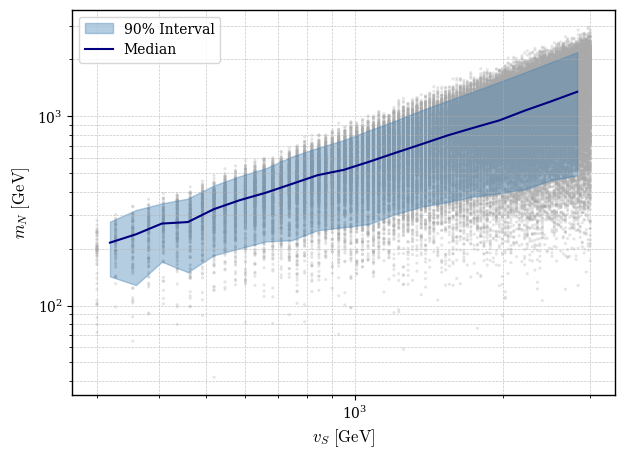

In [91]:
vS_plot, mN_plot = np.load('vS_inverse_seesaw.npy'), np.load('mN_inverse_seesaw.npy')

import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False,
})
plt.figure(figsize=(7,5))

plt.scatter(
    vS_plot,
    mN_plot,
    s=5,
    alpha=0.3,
    color='#A9A9A9',
    edgecolors='none'
)

plt.xlabel(r'$v_S\ \mathrm{[GeV]}$', fontsize=12)
plt.ylabel(r'$m_N\ \mathrm{[GeV]}$', fontsize=12)

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=10)

# Clean, journal-style axes
for spine in ax.spines.values():
    spine.set_linewidth(1.0)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)


#vS_vals, mN_vals = zip(*light_heavy_passes)
vS_vals, mN_vals = np.array(vS_plot), np.array(mN_plot)

bins = np.logspace(np.log10(300), np.log10(3000), 20) # I used 10 bins, because in the end we were looking only in the range 2000 - 3000 GeV, for 100 events
vS_centers = vS_centers = np.sqrt(bins[:-1] * bins[1:]) # Centers of the bins

p05, p50, p95 = [], [], []

for i in range(len(bins)-1):
    mask = (vS_vals >= bins[i]) & (vS_vals < bins[i+1])
    if np.sum(mask) < 10:
        p05.append(np.nan)
        p50.append(np.nan)
        p95.append(np.nan)
        continue
    p05.append(np.percentile(mN_vals[mask], 5))
    p50.append(np.percentile(mN_vals[mask], 50))
    p95.append(np.percentile(mN_vals[mask], 95))


plt.fill_between(vS_centers, p05, p95, alpha=0.4, color='#4682B4', label=r'90% Interval')
plt.plot(vS_centers, p50, 'k-', color='#000080', label='Median')
plt.legend(fontsize=10)

plt.xscale('log')
plt.yscale('log')

plt.savefig('inverse_seesaw_lightest_heavy_vs_vS.pdf', format='pdf')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Count')

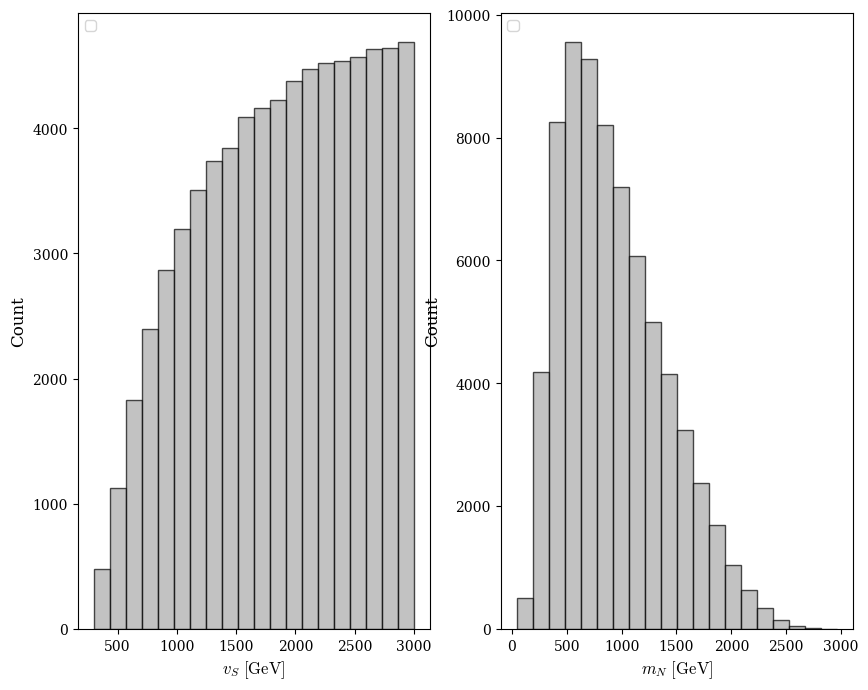

In [93]:
#Histogram for vS

fig, ax = plt.subplots(1, 2, figsize=(10,8))

vS_vals, mN_vals = np.array(vS_plot), np.array(mN_plot)

bins = np.logspace(np.log10(300), np.log10(3000), 20) # I used 10 bins, because in the end we were looking only in the range 2000 - 3000 GeV, for 100 events
vS_centers = vS_centers = np.sqrt(bins[:-1] * bins[1:]) # Centers of the bins

ax[0].hist(vS_vals, bins=20, color='#A9A9A9', edgecolor='black', alpha=0.7)
ax[0].legend(loc='upper left', frameon=True, framealpha=0.8)
ax[0].set_xlabel(r'$v_S\ \mathrm{[GeV]}$', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)

ax[1].hist(mN_vals, bins=20, color='#A9A9A9', edgecolor='black', alpha=0.7)
ax[1].legend(loc='upper left', frameon=True, framealpha=0.8)
ax[1].set_xlabel(r'$m_N\ \mathrm{[GeV]}$', fontsize=12)
ax[1].set_ylabel('Count', fontsize=12)

In [65]:
# '''In here I want to creat a statistical meaningfull representation. So I will bin in vS and get percentiles of mN in each bin.
# We can see in the plot that the preferred masses are of order 1 TeV, so we can expect that the median will be around there.'''


# vS_vals, mN_vals = zip(*light_heavy_passes)
# vS_vals, mN_vals = np.array(vS_vals), np.array(mN_vals)

# bins = np.linspace(1000, 3000, 20) # I used 10 bins, because in the end we were looking only in the range 2000 - 3000 GeV, for 100 events
# vS_centers = 0.5*(bins[:-1] + bins[1:]) # Centers of the bins

# p05, p50, p95 = [], [], []

# for i in range(len(bins)-1):
#     mask = (vS_vals >= bins[i]) & (vS_vals < bins[i+1])
#     if np.sum(mask) < 9:
#         p05.append(np.nan)
#         p50.append(np.nan)
#         p95.append(np.nan)
#         continue
#     p05.append(np.percentile(mN_vals[mask], 5))
#     p50.append(np.percentile(mN_vals[mask], 50))
#     p95.append(np.percentile(mN_vals[mask], 95))


# plt.figure(figsize=(7,5))
# plt.fill_between(vS_centers, p05, p95, alpha=0.3, label='90% interval')
# plt.plot(vS_centers, p50, 'k-', label='median')
# #plt.yscale('log')
# plt.xlabel(r'$v_S\,[\mathrm{GeV}]$')
# plt.ylabel(r'$m_{N_1}\,[\mathrm{GeV}]$')
# plt.legend()
# plt.title('LFV-allowed heavy neutrino mass bands')
# plt.scatter(vS_vals, mN_vals, alpha=0.1, s=1, color='gray', label='Raw Samples')
# plt.show()



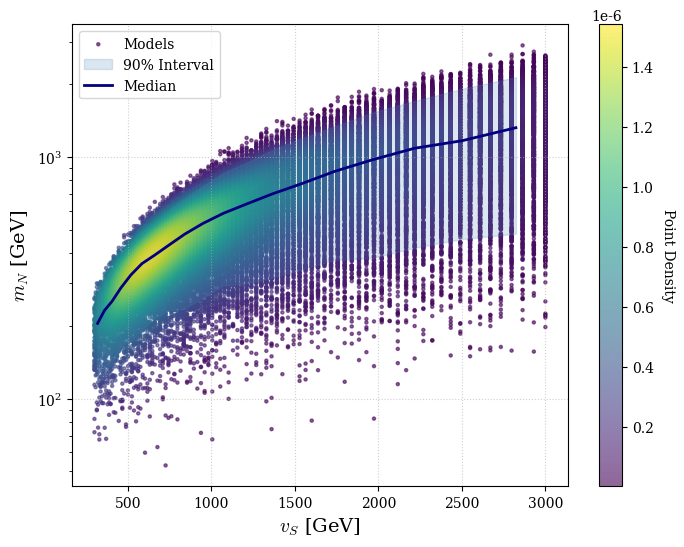

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 1. Calculate the density for the scatter points
# Assuming your data variables are vS_data and mN_data
#vs_data, mN_data = zip(*light_heavy_passes)
#vS_data = np.array(vs_data)
#mN_data = np.array(mN_data)

xy = np.vstack([vS_plot, mN_plot])
z = gaussian_kde(xy)(xy)

# Sort the points by density so that the densest points are plotted on top
idx = z.argsort()
x, y, z = vS_plot[idx], mN_plot[idx], z[idx]

fig, ax = plt.subplots(figsize=(8, 6))

# 2. Plot the Density Scatter
# Using the 'viridis' or 'inferno' colormap looks great for density
scatter = ax.scatter(x, y, c=z, s=5, cmap='viridis', alpha=0.6, label='Models')

# 3. Plot the 90% Interval and Median (using the Navy/Gray palette)
ax.fill_between(vS_centers, p05, p95, color='#4682B4', alpha=0.2, label='90% Interval')
ax.plot(vS_centers, p50, color='#000080', lw=2, label='Median')

# 4. Styling (Safe from LaTeX errors)
ax.set_xlabel(r'$v_S$ [GeV]', fontsize=14)
ax.set_ylabel(r'$m_N$ [GeV]', fontsize=14)
ax.grid(True, linestyle=':', alpha=0.6)

# Create a colorbar for the density
cbar = plt.colorbar(scatter)
cbar.set_label('Point Density', rotation=270, labelpad=15)

ax.legend(loc='upper left', frameon=True, framealpha=0.8)

plt.xscale('log')
plt.yscale('log')

# 5. Robust saving (replaces tight_layout)
plt.savefig('inverse_seesaw_density.pdf', bbox_inches='tight')
plt.show()

In [84]:
'''Let us do now an analysis considering 0vbb.'''

G1 = np.load('G1_inverse_seesaw.npy')
m_heavy = np.load('heavy_masses_inverse_seesaw.npy')
W1 = np.load('W1_inverse_seesaw.npy')
masses_heavy = np.load('eigvals_inverse_seesaw.npy')


rotation = [G1[i] @ W1[i] for i in range(len(G1))]

mll_light = 0
for i in range(3):
    mll_light += pmns_NO[0,i]**2 * light_neutrinos[i]
mll_light_abs = np.abs(mll_light)

mll_heavy = []
for i in range(len(G1)):
    result_run = rotation[i][0]**2 @ masses_heavy[i]
    mll_heavy.append(result_run)

sum_mll = np.abs(mll_light + mll_heavy)

mll_sum = np.array(sum_mll)

mll_all = np.array(np.abs(mll_heavy))

#Let us make it eV

mll_sum = mll_sum * 1e9
mll_all = mll_all * 1e9
mll_light_abs = mll_light_abs * 1e9


/tmp/ipykernel_8159/139780893.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(vS_centers, p50, 'k-', color='#000080', label='Median', zorder=3)


Text(0, 0.5, '$\\langle m_{ee} \\rangle \\ \\mathrm{[eV]}$')

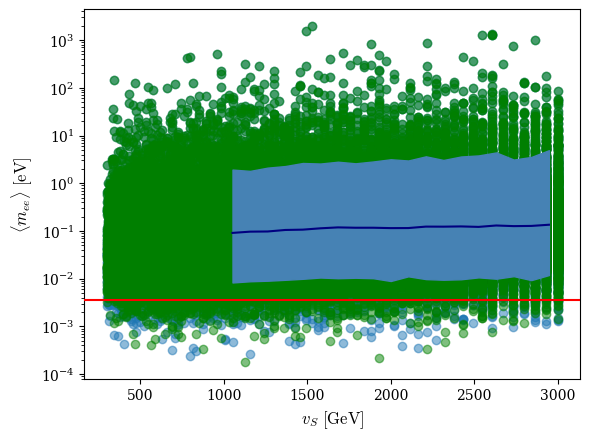

In [85]:
plt.plot(vS_plot, mll_all, 'o', alpha=0.5,zorder=1,)
plt.plot(vS_plot, mll_sum, 'o', alpha=0.5, color='g', label=r'Sum of Contributions',zorder=2)

bins = np.linspace(1000, 3000, 20) # I used 10 bins, because in the end we were looking only in the range 2000 - 3000 GeV, for 100 events
vS_centers = 0.5*(bins[:-1] + bins[1:]) # Centers of the bins

p05, p50, p95 = [], [], []

for i in range(len(bins)-1):
    mask = (vS_vals >= bins[i]) & (vS_vals < bins[i+1])
    if np.sum(mask) < 100:
        p05.append(np.nan)
        p50.append(np.nan)
        p95.append(np.nan)
        continue
    p05.append(np.percentile(mll_sum[mask], 5))
    p50.append(np.percentile(mll_sum[mask], 50))
    p95.append(np.percentile(mll_sum[mask], 95))

plt.axhline(mll_light_abs, color='r', linestyle='-', label=r'Light Neutrino Contribution', zorder = 4)
plt.fill_between(vS_centers, p05, p95, alpha=1, color='#4682B4', label=r'90% Interval',zorder=3)
plt.plot(vS_centers, p50, 'k-', color='#000080', label='Median', zorder=3)



#plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$v_S\ \mathrm{[GeV]}$', fontsize=12)
plt.ylabel(r'$\langle m_{ee} \rangle \ \mathrm{[eV]}$', fontsize=12)

In [86]:
len(mll_sum)

54592

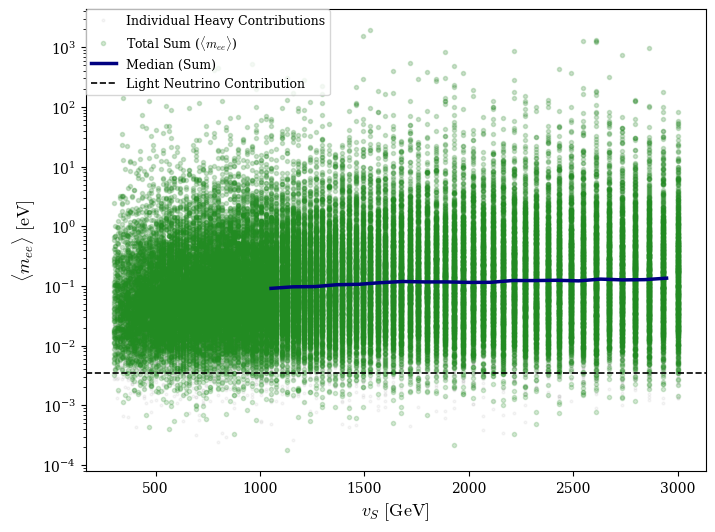

In [87]:
# 1. Individual Contributions (The 'Background' physics)
# Using a lighter, neutral color so it doesn't compete with the sum
fig, ax = plt.subplots(figsize=(8,6))

plt.plot(vS_plot, mll_all, 'o', markersize=2, alpha=0.1, color='#A9A9A9', 
         label=r'Individual Heavy Contributions', zorder=1)

# 2. Total Sum (The 'Main' physics)
# Using a vibrant Forest Green to make the total points stand out
plt.plot(vS_plot, mll_sum, 'o', markersize=3, alpha=0.2, color='#228B22', 
         label=r'Total Sum ($\langle m_{ee} \rangle$)', zorder=2)

# --- (Statistical processing code remains the same) ---



# 4. The Median
# A thick, solid Navy Blue line to anchor the plot
plt.plot(vS_centers, p50, '-', color='#000080', linewidth=2.5, 
         label='Median (Sum)', zorder=5)

# 5. Light Neutrino Limit
# Standard Black dashed line for the baseline
plt.axhline(mll_light_abs, color='black', linestyle='--', linewidth=1.2, 
            label=r'Light Neutrino Contribution', zorder=4)

plt.yscale('log')
plt.xlabel(r'$v_S\ \mathrm{[GeV]}$', fontsize=13)
plt.ylabel(r'$\langle m_{ee} \rangle \ \mathrm{[eV]}$', fontsize=13)
plt.legend(loc='upper left', borderaxespad=0, fontsize=9)
plt.savefig('inverse_seesaw_0vbb_contributions.pdf', format='pdf', bbox_inches='tight')